# Part 4: Model Estimation

**Table of contents:**

- **Topic & Model & Data, Description** 
<br />

- **Model Description and Regression**
<br />

- **Interpretation, and Discussions**


---
##  Short Description for My Topic, Model and Data
<br />

- **Topic:** **"How does a 10% increase in the price of Canada-produced canola seeds impact CO2 emissions from agriculture?"**

- **Model**: The model estimates the **long-run price elasticity of canola supply** using OLS regression.

**Raw Data:** 

- "Supply and disposition of grains in Canada."

    - Disposition of grains in Canada in metric tonnes. Obersvations are measured in a frequency of 3 times a year, in the March, July, and December. 

    - Source https://www150.statcan.gc.ca/t1/tbl1/en/cv.action?pid=3210001301

<br />

- "Raw materials price index for crop products, animals and animal products, monthly": 

    - The price indices for major crop products in Canada, on a basis of 100 at Jan. 2020. Observations are taken monthly.
    - Source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810026803&cubeTimeFrame.startMonth=01&cubeTimeFrame.startYear=1981&cubeTimeFrame.endMonth=09&cubeTimeFrame.endYear=2024&referencePeriods=19810101%2C20240901
    
<br />
    
- **Cleaned data:** "data_canolaPQ_soyP-Copy1.csv"
    
    - **"Total_disposition_MetricTonnes"**: The disposition quantity of **canola** in Canada, in metric tonnes.
    
    - **"Canola_PI_base202001"**: The price indices for **canola** in Canada, on a basis of 100 at Jan. 2020.

    - The logged term of these variables. 
    
    - **"soy"**: The price index of **soybean** is also included in this data. Its logged term is an instrumental variable in this study.
    
    - Obersvations are adjusted to a frequency of 3 times a year, in the March, July, and December.

<br />

*Avereage canola mature period: 3.5 months.*

https://canolagrowers.com/wp-content/uploads/2014/11/Canola_Glossy2010_1.pdf

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import math as math

In [5]:
data = pd.read_csv("data_canolaPQ_soyP-Copy1.csv", header=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      84 non-null     int64  
 1   time                            84 non-null     object 
 2   Total_disposition_MetricTonnes  84 non-null     float64
 3   Canola_PI_base202001            84 non-null     float64
 4   log_Q_canola                    84 non-null     float64
 5   log_P_canola                    84 non-null     float64
 6   soy                             84 non-null     float64
 7   log_P_soy                       84 non-null     float64
dtypes: float64(6), int64(1), object(1)
memory usage: 5.4+ KB


In [30]:

# data["time"]#.astype(str)
# data['time_num'] = data['time'].apply(lambda x: x.timestamp())
data['time'] = pd.to_datetime(data['time'])
# type(data["time"])
data['year'] = data['time'].dt.year

<Axes: title={'center': 'Log of Canola Price vs. Log of Canola Quantity'}, xlabel='Logged Price Index ', ylabel='Logged Quantity'>

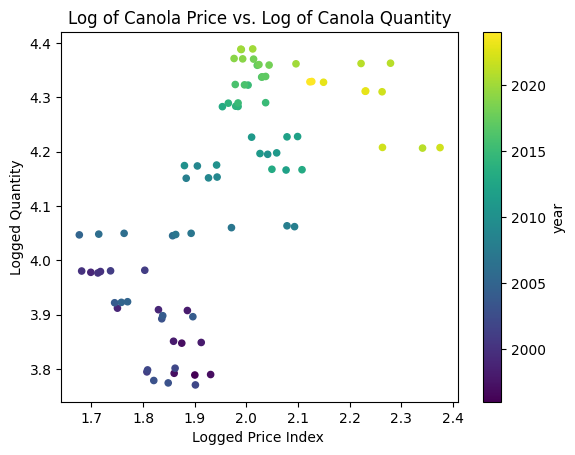

In [29]:
data.plot.scatter(x="log_P_canola", y= "log_Q_canola", 
                         xlabel="Logged Price Index ", ylabel="Logged Quantity", 
                         title="Log of Canola Price vs. Log of Canola Quantity", 
                         c="year", colormap='viridis' 
                         )

<Axes: title={'center': 'Differenced Log of Canola Price vs. Differenced \nLog of Canola Quantity'}, xlabel='Differenced Log Price Index ', ylabel='Differenced Log Quantity'>

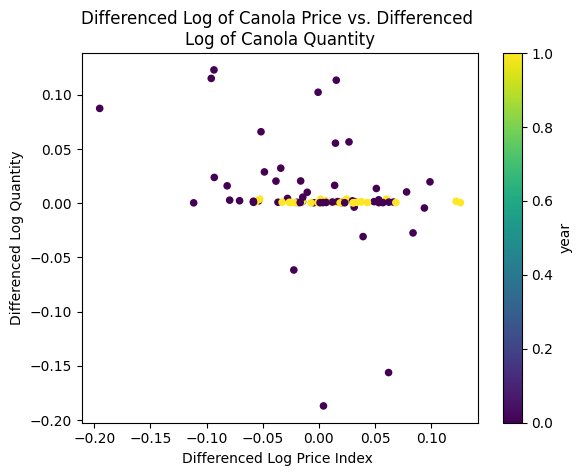

In [31]:
data_diff = data.diff().dropna()
data_diff.rename(columns={"log_Q_canola": "diff_log_Q_canola", 
                          "log_P_canola": "diff_log_P_canola"}, inplace=True) # inplace assigns values back. like data_diff = data_diff.rename(
data_diff.head()

data_diff.plot.scatter(x="diff_log_P_canola", y= "diff_log_Q_canola", 
                         xlabel="Differenced Log Price Index ", ylabel="Differenced Log Quantity", 
                         title="Differenced Log of Canola Price vs. Differenced \nLog of Canola Quantity", 
                         c="year", colormap='viridis' 
                         )

---
## Model Description and Regression

The model estimates the **long-run price elasticity of canola supply** using OLS regression. This elasticity measures the responsiveness of canola production to changes in its price, capturing how producers adjust their output over time in response to market conditions. 

<br />

### Structural Model (LR Supply):

$$\log q_{it} = \alpha + \gamma x_{it} + \beta \log p_{it} + \eta_{it}$$

<br />

- **Dependent Variable:** $\log q_{it}$

    - The dependent variable is the log of canola production , which reflects the natural logarithm of the total quantity of canola produced in a given period. 

- **Regressor for Key Elasticity:** $\log p_{it}$

    - We use the log of canola price  to recover the key elasticity. Canola price is endogenous, since it is affected by both supply and demand. 
  
   - $\beta: $ Constant price elasticity of supply. The coefficient on the logged term represents the percentage change in canola quantity for a 1% change in logged price index.
       
**Exogenous Shifter:**  $\log{x_{it}}$

Logged soybean price, which affects supply directly and indirectly via price adjustments. We use the reduced form ("Medium Case") method to estimate the total equilibrium effect of the shifter on canola production and price.
    
   - $\gamma: $ Direct effect of the shifter soybean price index $x_{it}$.

<br />





### 2SLS Using log Soy Price as an IV 


**Establish:**  $$\log q_{it} = \alpha + \gamma x_{it} + \beta \log p_{it} + \eta_{it}$$

**Stage 1:** $ \ \log{q} = \alpha + \beta x + \epsilon$ $\implies \log{\hat{p}} = \hat{\alpha} + \hat{\beta} x $ 


**Stage 2**: $ \ \log{q} = \alpha + \gamma \log{\hat{p}} + \epsilon_2$

And $\beta$ is the key elasticity of supply.


### First Stage
Check instrument strength.

$\text{p-value} \approx = 0.000$ , no weak IV issue.


In [41]:
model_1st = smf.ols('log_Q_canola ~ log_P_soy', data = data).fit()
model_1st.summary()#['coef']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_Q_canola   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     52.94
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           1.86e-10
Time:                        22:28:06   Log-Likelihood:                 37.837
No. Observations:                  84   AIC:                            -71.67
Df Residuals:                      82   BIC:                            -66.81
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.1552      0.271      7.940      0.000       1.615       2.695
log_P_soy      0.9886      0.136      7.276      0.000       0.718       1.259
==============================================================================
Omnibus:                        2.159   Durbin-Watson:                   0.200
Prob(Omnibus):                  0.340   Jarque-Bera (JB):                1.903
Skew:                          -0.253   Prob(JB):                        0.386
Kurtosis:                       2.463   Cond. No.                         39.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2SLS

$\hat{\beta}=2.0983$ , p-value $\approx 0.0000$ , R-squared: $0.9964$

In [30]:
# ! pip install linearmodels
import statsmodels.api as sm  
from linearmodels.iv import IV2SLS

In [43]:
model_2s = IV2SLS.from_formula(formula="log_Q_canola~[log_P_canola~log_P_soy]", data=data).fit()
model_2s

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:           log_Q_canola   R-squared:                      0.9964
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9964
No. Observations:                  84   F-statistic:                 2.255e+04
Date:                Mon, Nov 25 2024   P-value (F-stat)                0.0000
Time:                        22:57:55   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
================================================================================
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
log_P_canola     2.0983     0.0140     150.18     0.0000      2.0709      2.1257
================================================================================

Endogenous: log_P_canola
Instruments: log_P_soy
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x711ddb40d3a0

### Simple OLS

Compare to simple linear regression.

$\hat{\beta}=0.1025$ , p-value $=0.020$ , R-squared: $0.850$

In [44]:
model_ols = smf.ols('log_P_canola ~ log_P_soy + log_Q_canola', data = data).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_P_canola   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     229.8
Date:                Mon, 25 Nov 2024   Prob (F-statistic):           4.08e-34
Time:                        22:58:02   Log-Likelihood:                 117.11
No. Observations:                  84   AIC:                            -228.2
Df Residuals:                      81   BIC:                            -220.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.5197      0.141     -3.677      0.000      -0.801      -0.238
log_P_soy        1.0324      0.068     15.126      0.000       0.897       1.168
log_Q_canola     0.1025      0.043      2.369      0.020       0.016       0.188
==============================================================================
Omnibus:                        5.889   Durbin-Watson:                   0.680
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                8.441
Skew:                           0.174   Prob(JB):                       0.0147
Kurtosis:                       4.513   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

---
##  Interpretation, and Discussions

### Interpretation of Regression Results

- **Estimate:** $\hat{\beta}= 2.0983$ The estimated price elasticity of supply for canola is approximately 2.10. A 1% increase in canola price is expected to cause a 2.1% increase in canola production in the long run. The positive sign aligns well with our assumption of supply curve.

- **Significance**: p-value $\approx 0.0000$ is very significant, controlling type-1 error at 0.05 level.

- **Goodness of Fit:** R-squared: $0.9964$. The model explains 99.64% of the total variations. This indicates strong predictive relationship between soybean price (the IV) and canola price/quantity.

 - **Risk of inflating Type-1 Error:** 
    - With a small sample size ($n= 84$), the p-value can be misleadingly small due to overfitting. The extremely high R-squared value could also be due to overfitting. But our model is sparse, which could ease the issue of overfitting.

    - Violation to statistical assumptions (like normality and homoscedasticity, which are not yet verified in this study), can also inflate the test statistics and p-values.

    - Also, the assumption of independent errors is likely violated because of the nature of time series data. This may lead to bias in our prediction.


### Assumptions

**IV-Specific Assumptions:**

1. **Robustness:** $\log{x_{it}}$ (logged soybean price) is strongly correlated with $\log{p_{it}}$ (canola price). The $\text{p-value} \approx = 0.000$ in the first stage regression is statistically significant, indicating no weak IV issue.


2. **Exclusion Restriction:** The soybean price affects canola production only through affecting canola price. 

3. **Exogeneity of the Instrument:** The IV must not be influenced by shocks to Canadian canola production or prices.
    
    - This assumption likely holds because: Canada is not a major producer of soybeans (as compared to the U.S., or Brazil), so domestic canola-specific shocks are unlikely to influence soybean prices.
Soybean price should reflect global market conditions (e.g., weather in South America, U.S. policy), which are independent of Canadian canola supply or demand.

**Other assumptions:**

1. **Long-run Supply:** We assume that the data points can be regressed to a supply curve, and the fluctuations are due to demand shocks. The model assumes that producers have had sufficient time to adjust to price changes by altering acreage, crop rotations, and resource allocation. And the analysis captures long-run rather than short-run elasticity. 
    
    - Long-run dynamics are supported by the 28-year dataset, spanning multiple planting cycles where structural adjustments can occur. 
    

2. **Constant Elasticity:** The supply curve is log-linear, meaning the elasticity of supply is constant across all observed prices and quantities.
We are modeling aggregated data over multiple years, smoothing out short-term fluctuations, and focusing on the long-run relationship.

3. **No additional confounders:** Other factors (e.g., weather, input costs) affecting canola production or price are held constant, or at least have minimal impact.

